In [6]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM.MinimalModelV2

In [7]:
using OhMyThreads
using ProgressMeter
using JLD2
using ColorSchemes

In [8]:
includet("../../scripts/figures_util.jl")

using GLMakie
using CairoMakie
CairoMakie.activate!()

# Setup

## K v l phase diagram

In [9]:
function do_Kl_pd_run(logKs, epsilons;
    m=1.,
    k=0.,
    c=1.,
    d=1.,
    r=1.,
    DN=1e-12, DI=1., DR=1.,
    return_raw=false,
)
    rslts = Matrix{Vector{NospaceSolStability.T}}(undef, length(logKs), length(epsilons))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, e) in enumerate(epsilons)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m,
                    l=(1-e),
                    k,
                    c,
                    d,
                    r,
                );
                DN, DI, DR,
            )
        end
    end
    if return_raw
        rslts
    else
        nospacesolstabilities_to_code.(rslts)
    end
end

do_Kl_pd_run (generic function with 1 method)

# Phase diagrams

In [24]:
function make_Kl_pd(;
    logKs=range(-0.5, 4, 800),
    leak_xs=range(-5, 5, 300),
    tick_epsilons = [0.99, 0.9, 0.5, 0.1, 0.01],
    m=1.,
    r=1.,
    c=1.,
    DN=1e-12,
    DI=1.,
    DR=1.,
)
    Ks = 10 .^ logKs
    epsilons = LeakageScale.e.(leak_xs)
    
    xx = do_Kl_pd_run(logKs, epsilons;
        m,
        DN, DI, DR,
    )
    cs = PaperColors.mma_coloring_full.(xx)
    
    fig = Figure(;
        size=(double_col_width * 0.25, double_col_width * 0.18),
        default_fig_kwargs...,
        # figure_padding=tuple(fill(3., 4))
        figure_padding=(2., 8., 2., 2.)
    )
    
    ax = Axis(fig[1,1];
        xscale=log10,
        xlabel=L"K,\enspace\text{Amount of energy being supplied}",
        xlabelpadding=-1.,
        yticks=(LeakageScale.etox.(tick_epsilons), [(@sprintf "%.2g" e) for e in tick_epsilons]),
        ylabel=L"\epsilon,\enspace\text{Usage of influx resource}",
    )
    
    heatmap!(ax, Ks, leak_xs, cs;
        rasterize=3
    )

    extline1_Ks = MinimalModelV2.fr_ext_line_K.(1 .- epsilons, m, c, r)
    instabline1_Ks = MinimalModelV2.fr_instab_line_K.(1 .- epsilons, m, c, r)
    instabline2_Ks = MinimalModelV2.fr_cor1_instab_line_K.(1 .- epsilons, m, c, DR / DI, r)
    
    lines!(ax, extline1_Ks, leak_xs;
        color=PaperColors.mm_extline(),
        linewidth=1.,
    )
    lines!(ax, instabline1_Ks, leak_xs;
        color=PaperColors.mm_instabline(),
        linewidth=1.,
    )
    lines!(ax, instabline2_Ks, leak_xs;
        color=PaperColors.mm_instabline(),
        linewidth=1.,
    )

    xlims!(ax, extrema(Ks)...)
    
    FigureAxisAnything(fig, ax, [])
end

make_Kl_pd (generic function with 1 method)

  0.959593 seconds (54.13 M allocations: 3.136 GiB, 33.55% gc time)


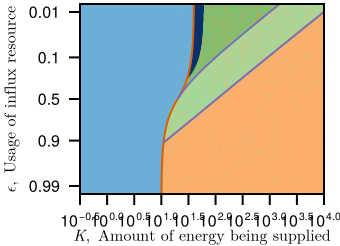

In [28]:
@time f = make_Kl_pd(;
    # logKs=range(-2.1, 0.5, 500),
    m=10.,
    # m=0.01,
    # DN=1e-6,
    DN=0.,
    DI=1.,
    DR=0.1,
)
# Makie.save("./k.pdf", f.figure)

In [21]:
f = make_Kl_pd()
f.axis.title = L"m=1, D_R=D_I"
f.axis.titlegap = 2.
@time Makie.save("../../figures/fig2/Kl_pd_base.pdf", f.figure)

f = make_Kl_pd(m=10., DR=0.5)
f.axis.title = L"m=10, D_R=\frac{D_I}{2}"
f.axis.titlegap = 2.
@time Makie.save("../../figures/fig2/Kl_pd_both.pdf", f.figure)

  0.740442 seconds (471.63 k allocations: 44.587 MiB, 60.15% compilation time)
  0.283947 seconds (50.69 k allocations: 15.916 MiB)


CairoMakie.Screen{PDF}


# Diffusion heatmap

## Generate data

In [98]:
DIs = 10 .^ range(-12, 1, 30)
DRs = 10 .^ range(-12, 1, 30)

logKs=range(-0.5, 4, 100)
leak_xs=range(-5, 5, 100)
ls = LeakageScale.l.(leak_xs)

props = Matrix{Float64}(undef, length(DIs), length(DRs))
pb = Progress(length(props))
for i in 1:length(DIs)
    for j in 1:length(DRs)
        rslts = Matrix{Any}(undef, length(logKs), length(ls))
        @tasks for Ki in 1:length(logKs)
            logK = logKs[Ki]
            for (li, l) in enumerate(ls)
                rslts[Ki, li] = analyse_mmp(
                    MMParams(;
                        K=10 ^ logK,
                        m=1.,
                        l=l,
                        k=0.,
                        c=1.,
                        d=1.,
                    );
                    DN=1e-12,
                    DI=DIs[i],
                    DR=DRs[j],
                )
            end
        end
        codes = nospacesolstabilities_to_code.(rslts)
        num_unstable = count(x->(x == 3) || (x == 13), codes)
        props[i, j] =  num_unstable / length(codes)
        next!(pb)
    end
end
finish!(pb)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


In [99]:
jldsave("./figures_data/mm_diff_pd_temp.jld2"; DIs, DRs, logKs, ls, props)

## Plot

In [109]:
@load "./figures_data/mm_diff_pd.jld2" DIs DRs props;
nprops = copy(props)
nprops ./= maximum(nprops);

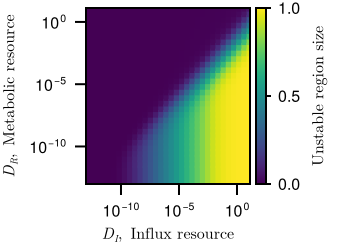

In [136]:
fig = Figure(;
    size=(double_col_width * 0.25, double_col_width * 0.18),
    default_fig_kwargs...,
    # figure_padding=tuple(fill(3., 4))
    figure_padding=(2., 8., 2., 4.)
)
ax = Axis(fig[1,1];
    # aspect=DataAspect(),
    xlabel=L"D_I,\enspace\text{Influx resource}",
    ylabel=L"D_R,\enspace\text{Metabolic resource}",
    xscale=log10,
    yscale=log10,
)

hm = heatmap!(ax, DIs, DRs, nprops;
)

Colorbar(fig[1,2], hm;
    label=L"\text{Unstable region size}",
    size=5.,
    ticksize=2.,
)

colgap!(fig.layout, 3.)

Makie.save("../../figures/fig2/diffusions_heatmap.pdf", fig)

fig

# Changing both DI and DR together

In [94]:
Ds = 10 .^ range(-12, 1, 20)

logKs = range(-0.5, 3, 100)
ls = range(0., 1., 100)

D_props = []
for D in Ds
    rslts = Matrix{Any}(undef, length(logKs), length(ls))
    @tasks for i in 1:length(logKs)
        logK = logKs[i]
        for (j, l) in enumerate(ls)
            rslts[i, j] = analyse_mmp(
                MMParams(;
                    K=10 ^ logK,
                    m=1.,
                    l=l,
                    k=0.,
                    c=1.,
                    d=1.,
                );
                DN=1e-12,
                DI=D,
                DR=D,
            )
        end
    end
    codes = nospacesolstabilities_to_code.(rslts)
    num_unstable = count(x->(x == 3) || (x == 13), codes)
    push!(D_props, num_unstable / length(codes))
end

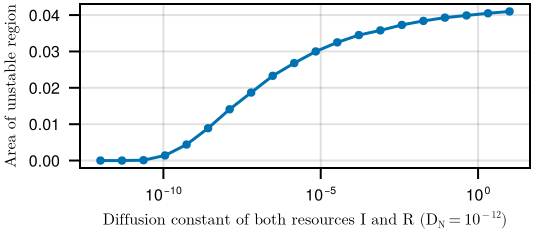

In [95]:
fig = Figure(;
    size=(double_col_width * 0.4, double_col_width * 0.17),
    default_fig_kwargs...,
    # figure_padding=tuple(fill(3., 4))
    figure_padding=(2., 8., 2., 2.)
)
ax = Axis(fig[1,1];
    ylabel=L"\text{Area of unstable region}",
    xlabel=L"\text{Diffusion constant of both resources $I$ and $R$ ($D_N = 10^{-12}$)}",
    xscale=log10,
)

scatterlines!(ax, Ds, D_props)

Makie.save("../../figures/fig2/DI_DR_diffusionplot.pdf", fig)

fig